## Setup

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord

from gammapy.maps import WcsGeom, MapAxis, WcsNDMap
from gammapy.image.models import SkyPointSource
from gammapy.spectrum.models import Absorption, AbsorbedSpectralModel
from gammapy.cube.models import SkyModel
from gammapy.astro.darkmatter import DMAnnihilation, SigmaVEstimator

from gammapy.irf import load_cta_irfs
from gammapy.utils.fitting import Fit
from gammapy.cube.simulate import simulate_dataset

## Load IRFs

In [2]:
filename = "$CTADATA/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
irfs = load_cta_irfs(filename)

## Define map geometry

In [3]:
GLON = 96.34 * u.Unit("deg")
GLAT = -60.19 * u.Unit("deg")
src_pos = SkyCoord(GLON, GLAT, frame="galactic")
emin = 0.03 
emax = 100
unit = "TeV"
lg_emin = np.log10(emin)
lg_emax = np.log10(emax)
ENERGY_BINS = 31

In [4]:
axis = MapAxis.from_edges(
    np.logspace(lg_emin, lg_emax, ENERGY_BINS),
    unit=unit,
    name="energy",
    interp="log",
)
geom = WcsGeom.create(
    skydir=src_pos, binsz=0.02, width=(2, 2), coordsys="GAL", axes=[axis]
)

## Declare observation values

In [5]:
pointing = src_pos
livetime = 50 * u.hour
offset = 2 * u.deg

## Build model and create dataset

**Declare constants and parameters for our DM model**

In [6]:
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # <--- point source
mDM = 5000*u.Unit("GeV")
channel = "b"
redshift = 5

**Define 3D Sky Model**

In [7]:
flux_model = DMAnnihilation(
    mass=mDM, 
    channel=channel, 
    jfactor=JFAC, 
    z=redshift
)

absorption_model = Absorption.read_builtin('dominguez')
flux_model = AbsorbedSpectralModel(flux_model, absorption_model, redshift)

spatial_model = SkyPointSource(lat_0=GLAT, lon_0=GLON)
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=flux_model
)

**Create simulated dataset**

In [8]:
simulated_ds = simulate_dataset(
    sky_model, 
    geom=geom, 
    pointing=pointing, 
    irfs=irfs, 
    livetime=livetime, 
    offset=offset
)

## Display our simulated dataset (optional)

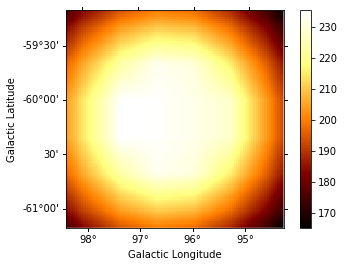

In [9]:
npred_map = simulated_ds.npred()
npred_map.sum_over_axes().plot(add_cbar=True);
#npred_map.plot_interactive(add_cbar=True);

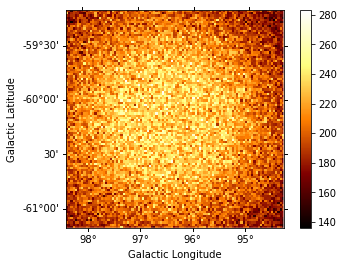

In [10]:
simulated_ds.counts.sum_over_axes().plot(add_cbar=True);
#simulate_dataset.counts.plot_interactive(add_cbar=True);

## Estimate sigma v

** Enable inspection **

In [11]:
import logging
logging.basicConfig()
logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("INFO")

** Instatiate estimator **

In [12]:
masses = [70, 200, 500, 5000, 10000, 50000, 100000]*u.GeV
channels = ["b", "t", "tau", "Z"] 
estimator = SigmaVEstimator(simulated_ds, masses, channels, jfact=JFAC)

** Run estimator and fetch results**

In [13]:
%%time
NumberOfRuns = 1
for run in range(NumberOfRuns):
    result = estimator.run()
    
## TODO HERE
## store results in a different data structure when fitting several runs

INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 70.0 GeV
INFO:gammapy.astro.darkmatter.utils:Sigma v: 5.9315909478840434e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:Mass: 200.0 GeV
INFO:gammapy.astro.darkmatter.utils:Sigma v: 1.0530501971816252e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:Mass: 500.0 GeV
INFO:gammapy.astro.darkmatter.utils:Sigma v: 6.448371908517366e-25 cm3 / s
INFO:gammapy.astro.darkmatter.utils:Mass: 5000.0 GeV
INFO:gammapy.astro.darkmatter.utils:Sigma v: 1.2376034123721894e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
INFO:gammapy.astro.darkmatter.utils:Sigma v: 1.3566166427884734e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:Mass: 50000.0 GeV
INFO:gammapy.astro.darkmatter.utils:Sigma v: 2.230280087108208e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:Mass: 100000.0 GeV
INFO:gammapy.astro.darkmatter.utils:Sigma v: 4.206442239551726e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:Channel: t
INFO:g

CPU times: user 5min 46s, sys: 2.5 s, total: 5min 48s
Wall time: 2min 55s


## Inspection of results

** Display results for channel tau**

In [14]:
result["tau"]["mass", "sigma_v"]

mass,sigma_v
GeV,cm3 / s
float64,float64
70.0,2.286953166521727e-25
200.0,1.4849190212097548e-25
500.0,1.9463869740544247e-25
5000.0,2.91263673479921e-25
10000.0,4.745733030313231e-25
50000.0,4.887946308519409e-24
100000.0,1.3467458645320972e-23


** Plot delta likelihood profile for a specific fit**

In [15]:
mask = result["b"]["mass"] == 5000
profile = result["b"]["likeprofile"][mask][0]
likemin = result["b"]["likemin"][mask][0]

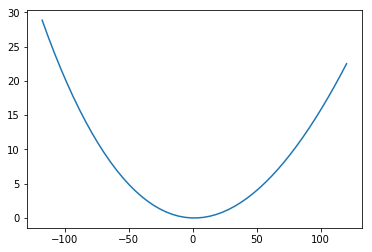

In [16]:
plt.plot(profile["values"], profile["likelihood"] - likemin);

## Plot obtained results for sigma

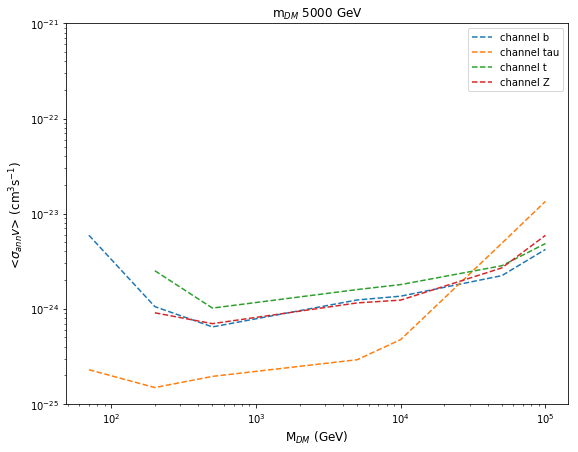

In [17]:
plt.figure(figsize=(9,7))
plt.ylim(1e-25, 1e-21)
plt.ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
plt.xlabel("M$_{DM}$ (GeV)", fontsize=12)
plt.title('m$_{DM}$ 5000 GeV')

for ch in ["b", "tau"]:
    plt.loglog(
        result[ch]["mass"].data,
        result[ch]["sigma_v"].data,
        ls="--",
        label='channel {}'.format(ch)
       )
#plot only not None values for sigma
for ch in ["t","Z"]:
    masses = result[ch]["mass"].data[1:]
    sigmas = result[ch]["sigma_v"].data[1:]
    plt.loglog(
        masses,
        sigmas,
        ls="--",
        label='channel {}'.format(ch)
       )
plt.legend();